In [3]:
!pip install nltk

  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)


In [ ]:
import json

def find_candidates_coco(captions, coco_json_path='captions_val2017.json'):
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)
    
    caption_dict = {}
    for annotation in coco_data['annotations']:
        caption = annotation['caption'].replace(' ', '').lower()
        image_id = annotation['image_id']
        filename = f'COCO_val2017_{image_id:012d}.jpg'
        caption_dict[caption] = filename
    
    return [caption_dict.get(caption, None) for caption in captions]

def find_candidates_imagenet(labels, imagenet_json_path='imagenet.json'):
    with open(imagenet_json_path, 'r') as f:
        imagenet_data = json.load(f)
    
    label_dict = {}
    for item in imagenet_data:
        label = item['label'].replace(' ', '').lower()
        filename = item['filename']
        if label not in label_dict:
            label_dict[label] = []
        label_dict[label].append(filename)
    
    return [label_dict.get(label, []) for label in labels]

def find_candidates_places365(labels, dataset='places_365_train'):
    candidates = []
    for model_name, dataset in datasets[dataset].items():
        for idx in range(len(dataset)):
            image, target = dataset[idx]
            if target in labels:
                candidates.append((model_name, idx, image))
    return candidates

In [3]:
import torch as th
import torch._dynamo.config
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder, DatasetFolder
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import json
import os

large_size = 256

common_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize(large_size),
    transforms.CenterCrop(large_size),
    transforms.Resize((large_size, large_size)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1),
])
with open('data/datasets/imagenet.json') as f:
    imagenet_labels = json.load(f)

def imagenet_target_transform(target):
    return imagenet_labels[int(datasets['imagenet_val'].classes[target])]



class CocoFolder(Dataset):
    def __init__(self, root, annotations_json, transform=None, target_transform=None):
        self.root = root
        self.transform = transform
        self.target_transform = target_transform

        with open(annotations_json) as f:
            coco_json = json.load(f)

        annotations_by_id = {_ann['image_id']: _ann for _ann in coco_json['annotations']}
        coco_filename_to_annotations = {_img['file_name']: annotations_by_id[_img['id']]['caption'] for _img in coco_json['images']}
        self.classes = list(set(coco_filename_to_annotations.keys()))
        self.classes.sort()

        all_files = os.listdir(root)
        all_images = [f for f in all_files if f.endswith('.jpg')]
        self.image_paths = [os.path.basename(f) for f in all_images]
        self.targets = [coco_filename_to_annotations[os.path.basename(f)] for f in all_images]
        self.image_paths = [os.path.join(root, f) for f in self.image_paths]
        self.samples = list(zip(self.image_paths, self.targets))
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        img = Image.open(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

datasets = {
    'imagenet_val': ImageFolder('data/datasets/ILSVRC2012_img_val_subset', transform=common_transform, target_transform=imagenet_target_transform),
    'coco_val2017': CocoFolder('data/datasets/val2017', 'data/annotations/captions_val2017.json', transform=common_transform),
    'places_365_train': ImageFolder('data/datasets/places365_standard/train', transform=common_transform, target_transform=lambda x: p365t_classes[x].replace("_", " ")),
    'places_365_val': ImageFolder('data/datasets/places365_standard/val', transform=common_transform,  target_transform=lambda x: p365v_classes[x].replace("_", " ")),
}

p365t_classes = datasets['places_365_train'].classes
p365v_classes = datasets['places_365_val'].classes

In [4]:
import re

def clean_target(target):
    return re.sub(r'\W+', '', target).lower()

def create_target_image_dict(datasets):
    target_image_dict = {}
    for dataset_name, dataset in datasets.items():
        target_image_dict[dataset_name] = {}
        for image, target in dataset:
            cleaned_target = clean_target(target)
            if cleaned_target not in target_image_dict[dataset_name]:
                target_image_dict[dataset_name][cleaned_target] = []
            target_image_dict[dataset_name][cleaned_target].append(image)
    return target_image_dict

target_image_dict = create_target_image_dict(datasets)

In [5]:
len(target_image_dict['places_365_train']['alcove'])

5

In [6]:
import os
import shutil
from nltk.corpus import words
import nltk

# Ensure you have the nltk words corpus downloaded
nltk.download('words')

def add_spaces_to_prompt(prompt):
    word_list = set(words.words())
    n = len(prompt)
    dp = [None] * (n + 1)
    dp[0] = []

    for i in range(1, n + 1):
        for j in range(i):
            word = prompt[j:i]
            if word in word_list:
                if dp[j] is not None:
                    dp[i] = dp[j] + [word]
                    break

    if dp[-1] is None:
        return prompt  # Return the original prompt if no segmentation is found
    return '_'.join(dp[-1])

def collect_images_for_upscale(base_path='data/samples', output_path='samples_to_upscale'):
    masks = ['ex64', 'genhalf', 'sr64', 'thick']
    datasets = os.listdir(base_path)

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    for dataset in datasets:
        dataset_path = os.path.join(base_path, dataset)
        if not os.path.isdir(dataset_path):
            continue

        for mask in masks:
            mask_path = os.path.join(dataset_path, mask)
            if not os.path.isdir(mask_path):
                continue

            models = os.listdir(mask_path)
            if not models:
                continue

            # Process filenames from the first model
            first_model_path = os.path.join(mask_path, 'original')
            if not os.path.isdir(first_model_path):
                continue

            images_dict = []
            for filename in os.listdir(first_model_path):
                if filename.endswith('.png'):
                    batch_num, prompt_og, id_ = filename[:-4].split('_')
                    prompt = add_spaces_to_prompt(prompt_og)
                    images_dict.append((filename, prompt, prompt_og))

            # Collect 160 images per mask
            collected_images = images_dict[:160]

            for model in models:
                model_path = os.path.join(mask_path, model)
                if not os.path.isdir(model_path):
                    continue

                # Create output directories
                output_dataset_path = os.path.join(output_path, dataset)
                if not os.path.exists(output_dataset_path):
                    os.makedirs(output_dataset_path)

                output_model_path = os.path.join(output_dataset_path, model)
                if not os.path.exists(output_model_path):
                    os.makedirs(output_model_path)

                # Copy images to the new structure
                for index, (filename, prompt, _) in enumerate(collected_images):
                    file_path = os.path.join(model_path, filename)
                    new_filename = f"{prompt}_{index}_{mask}.png"
                    shutil.copy(file_path, os.path.join(output_model_path, new_filename))
            for index, (filename, prompt, prompt_og) in enumerate(collected_images):
                    output_dataset_path = os.path.join(output_path, dataset)
                    if not os.path.exists(output_dataset_path):
                        os.makedirs(output_dataset_path)
                    out_path = os.path.join(output_dataset_path, "originals", f"{prompt}_{index}_{mask}")
                    if not os.path.exists(out_path):
                        os.makedirs(out_path)
                    images = target_image_dict[dataset][prompt_og.lower()]
                    for i, image in enumerate(images):
                        image = image.permute(1, 2, 0).cpu().numpy()
                        image = (image + 1) / 2 * 255
                        image = image.clip(0, 255).astype(np.uint8)
                        image = Image.fromarray(image)
                        new_filename = f"{i}.png"
                        image.save(os.path.join(out_path, new_filename))


[nltk_data] Downloading package words to
[nltk_data]     /home/infres/kbrowder-24/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [8]:
collect_images_for_upscale()

In [47]:
import os
from image_util import read_image
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms

class CustomImageDataset(Dataset):
    def __init__(self, image_paths, targets, mask_names, ids, transform=None):
        self.image_paths = image_paths
        self.targets = targets
        self.mask_names = mask_names
        indices = list(range(len(self.targets)))
        indices.sort(key=ids.__getitem__)
        self.image_paths = [self.image_paths[i] for i in indices]
        self.targets = [self.targets[i] for i in indices]
        self.mask_names = [self.mask_names[i] for i in indices]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = read_image(self.image_paths[idx], size=64)
        target = self.targets[idx]
        mask_name = self.mask_names[idx]
        if self.transform:
            image = self.transform(image)
        return image, (target, mask_name)
    
class CustomImageDatasetFolders(Dataset):
    def __init__(self, image_paths, targets, mask_names, ids, transform=None):
        self.image_paths = image_paths
        self.targets = targets
        self.mask_names = mask_names
        indices = list(range(len(self.targets)))
        indices.sort(key=ids.__getitem__)
        self.image_paths = [self.image_paths[i] for i in indices]
        self.image_paths = [os.path.join(p, os.listdir(p)[0]) for p in self.image_paths]
        self.targets = [self.targets[i] for i in indices]
        self.mask_names = [self.mask_names[i] for i in indices]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = read_image(self.image_paths[idx], size=256)
        target = self.targets[idx]
        mask_name = self.mask_names[idx]
        if self.transform:
            image = self.transform(image)
        return image, (target, mask_name)

def collect_images(base_path='samples_to_upscale'):
    datasets = {}
    transform = None

    for dset in os.listdir(base_path):
        dset_path = os.path.join(base_path, dset)
        if not os.path.isdir(dset_path):
            continue

        datasets[dset] = {}
        for model in os.listdir(dset_path):
            model_path = os.path.join(dset_path, model)
            if not os.path.isdir(model_path):
                continue
            if model != 'originals':
                image_paths = []
                targets = []
                mask_names = []
                ids = []
                for filename in os.listdir(model_path):
                    if filename.endswith('.png'):
                        promptid, mask_name = filename[:-4].rsplit('_', 1)
                        prompt, id_ = promptid.rsplit('_', 1)
                        prompt = prompt.replace('_', ' ')
                        image_paths.append(os.path.join(model_path, filename))
                        targets.append(prompt)
                        mask_names.append(mask_name)
                        ids.append(filename[:-4])

                datasets[dset][model] = CustomImageDataset(image_paths, targets, mask_names, ids, transform=transform)
            else:
                image_paths = []
                targets = []
                mask_names = []
                ids = []
                for filename in os.listdir(model_path, ):
                    if os.path.isdir(os.path.join(model_path, filename)):
                        promptid, mask_name = filename.rsplit('_',1)
                        prompt, id_ = promptid.rsplit('_', 1)
                        prompt = prompt.replace('_', ' ')
                        image_paths.append(os.path.join(model_path, filename))
                        targets.append(prompt)
                        mask_names.append(mask_name)
                        ids.append(filename)

                datasets[dset][model] = CustomImageDatasetFolders(image_paths, targets, mask_names, ids, transform=transform)

    return datasets

In [48]:
datasets = collect_images()

In [3]:
from image_util import show_images

In [49]:
datasets['places_365_val']['base'][8][1]

('airport terminal', 'ex64')

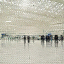

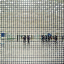

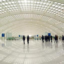

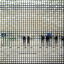

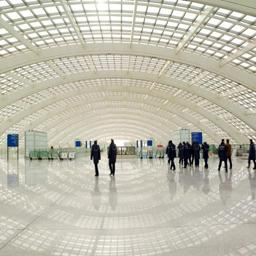

In [51]:
show_images(datasets['places_365_val']['repaint'][12][0])
show_images(datasets['places_365_val']['base'][12][0])
show_images(datasets['places_365_val']['original'][12][0])
show_images(datasets['places_365_val']['rpip'][12][0])
show_images(datasets['places_365_val']['originals'][12][0])

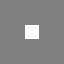

In [9]:
from image_util import *
show_images(masks['ex64'].repeat(1,3,1,1))

In [18]:
import repaint_sampling as RS
import repaint_patcher as RP
import prepare_glide_inpaint as PGI
from image_util import *
import torch as th
has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda:2')
# model, diffusion, options = PGI.create_glide_generative(device=device, cuda=has_cuda, timesteps='250')
# model_up, diffusion_up, options_up = PGI.create_glide_upsampler(device=device, cuda=has_cuda, timesteps='250')
# model_nip, diffusion_nip, options_nip = PGI.create_glide_generative(device=device, cuda=has_cuda, timesteps='250', use_inpaint=False)
model_up_nip, diffusion_up_nip, options_up_nip = PGI.create_glide_upsampler(device=device, cuda=has_cuda, timesteps='250', use_inpaint=False)


/home/infres/kbrowder-24/jp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/infres/kbrowder-24/jp/CSC_52002_EP_Generative_AI_Project/glide-text2im-main/glide_text2im/download.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user

In [6]:
guidance_scale = 7

In [3]:
masks = {
    'ex64': read_mask('data/masks/64/ex64.png', size=64),
    'genhalf': read_mask('data/masks/64/genhalf.png',size=64),
    'sr64': read_mask('data/masks/64/sr64.png',size=64),
    'thick': read_mask('data/masks/64/thick.png',size=64),
    'thin': read_mask('data/masks/64/thin.png',size=64),
    'vs64': read_mask('data/masks/64/vs64.png',size=64),
}

masks_large = {
    'ex64': read_mask('data/masks/64/ex64.png', size=256),
    'genhalf': read_mask('data/masks/64/genhalf.png',size=256),
    'sr64': read_mask('data/masks/64/sr64.png',size=256, resample=Image.NEAREST),
    'thick': read_mask('data/masks/64/thick.png',size=256),
    'thin': read_mask('data/masks/64/thin.png',size=256),
    'vs64': read_mask('data/masks/64/vs64.png',size=256, resample=Image.NEAREST),
}

In [7]:
# base_sampler = RS.CFGSamplerInpaint(model, diffusion, options, guidance_scale, device=device)
# upscale_sampler = RS.UpscaleSamplerInpaint(model_up, diffusion_up, options_up, model_fn=None, device=device)

from copy import deepcopy

# diffusion_rp = deepcopy(diffusion)
# diffusion_rp_up = deepcopy(diffusion_up)

# RP.patch_model_for_repaint(diffusion_rp)
# RP.patch_model_for_repaint(diffusion_rp_up)

# diffusion_rp_nip = deepcopy(diffusion_nip)
# diffusion_rp_up_nip = deepcopy(diffusion_up_nip)

# RP.patch_model_for_repaint(diffusion_rp_nip)
# RP.patch_model_for_repaint(diffusion_rp_up_nip)

jump_params = {
    "t_T": 250,
    "n_sample": 1,
    "jump_length": 10,
    "jump_n_sample": 6,
    "start_resampling": 30
}

jump_params_rp_nip = {
    "t_T": 250,
    "n_sample": 1,
    "jump_length": 10,
    "jump_n_sample": 5,
    "start_resampling": 150,
    "end_resampling": 50
}

In [8]:
# base_sampler_rp = RS.CFGSamplerRepaint(model_nip, diffusion_rp_nip, options_nip, guidance_scale, device=device)
# upscale_sampler_rp = RS.UpscaleSamplerRepaint(model_up_nip, diffusion_rp_up_nip, options_up_nip, model_fn=None, device=device)

# base_sampler_rpip = RS.CFGSamplerRepaintInpaint(model, diffusion_rp, options, guidance_scale, device=device)
# upscale_sampler_rpip = RS.UpscaleSamplerRepaintInpaint(model_up, diffusion_rp_up, options_up, model_fn=None, device=device)

In [9]:
upscaler_base = RS.UpscaleSampler(model_up_nip, diffusion_up_nip, options_up_nip, None, device=device)

upscaler_base.sample = torch.compile(upscaler_base.sample, mode="max-autotune")

In [10]:
batch_size = 32

res = {}
for name, dataset_d in datasets.items():
    for batch_i in range(0,635,batch_size):
        orig_image_64 = []
        base_image_64 = []
        rp_image_64 = []
        rpip_image_64 = []
        orig_image_256 = []
        prompts = []
        for i in range(batch_i, batch_i+batch_size):
            if i > len(dataset_d['original']):
                break
            prompts.append(dataset_d['original'][i][1])
            orig_image_64.append(dataset_d['original'][i][0])
            base_image_64.append(dataset_d['base'][i][0])
            rp_image_64.append(dataset_d['repaint'][i][0])
            rpip_image_64.append(dataset_d['rpip'][i][0])
            orig_image_256.append(dataset_d['originals'][i][0])
        if(len(prompts) < batch_size):
            break
        orig_image_64 = torch.cat(orig_image_64).to(device)
        base_image_64 = torch.cat(base_image_64).to(device)
        rp_image_64 = torch.cat(rp_image_64).to(device)
        rpip_image_64 = torch.cat(rpip_image_64).to(device)
        orig_image_256 = torch.cat(orig_image_256).to(device)
        up_base = upscaler_base.sample(base_image_64, 0.997, prompts, batch_size, {}, batch_prompts=True)
        up_base_rp = upscaler_base.sample(rp_image_64, 0.997, prompts, batch_size, {}, batch_prompts=True)
        up_base_rpip = upscaler_base.sample(rpip_image_64, 0.997, prompts, batch_size, {}, batch_prompts=True)
        os.makedirs(f'data/large_samples/{name}/base')
        os.makedirs(f'data/large_samples/{name}/repaint')
        os.makedirs(f'data/large_samples/{name}/rpip')
        save_batch(up_base, f'data/large_samples/{name}/base/' + '{0}_{1}.png', prompts)
        save_batch(up_base_rp, f'data/large_samples/{name}/repaint/' + '{0}_{1}.png', prompts)
        save_batch(up_base_rpip, f'data/large_samples/{name}/rpip/' + '{0}_{1}.png', prompts)


Batch prompts


  0%|          | 0/250 [00:00<?, ?it/s]/home/infres/kbrowder-24/jp/.venv/lib/python3.12/site-packages/torch/_inductor/compile_fx.py:167: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
  0%|          | 0/250 [01:40<?, ?it/s]


KeyboardInterrupt: 